In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pymks.datasets import make_elastic_stress_random

In [4]:
%%time
sample_size = 200
grain_size = [(15, 2), (2, 15), (7, 7), (8, 3), (3, 9), (2, 2)]
n_samples = [sample_size] * 6
elastic_modulus = (310, 200)
poissons_ratio = (0.28, 0.3)
macro_strain = 0.001
size = (21, 21)

X, y = make_elastic_stress_random(n_samples=n_samples, size=size, grain_size=grain_size,
                                      elastic_modulus=elastic_modulus, poissons_ratio=poissons_ratio,
                                      macro_strain=macro_strain, seed=0)

CPU times: user 1.5 s, sys: 1.76 s, total: 3.26 s
Wall time: 1.06 s


In [6]:
print(X.shape)
print(y.shape)

(1200, 21, 21)
(1200,)


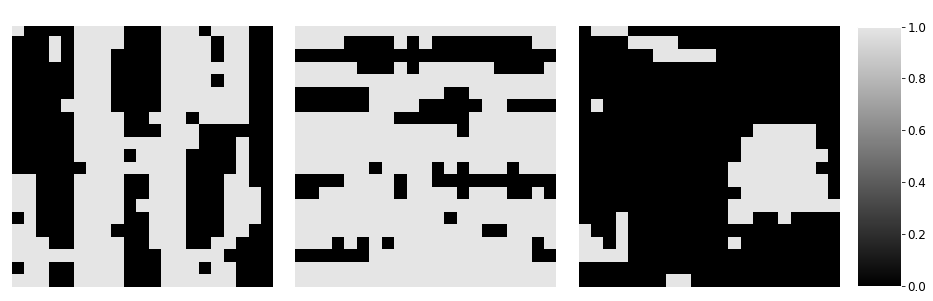

In [8]:
from pymks.tools import draw_microstructures

X_examples = X[::sample_size]
draw_microstructures(X_examples[:3])

In [9]:
print('Stress Values', y[::200])

Stress Values [0.2502349  0.22144102 0.2860063  0.26032831 0.25110925 0.25015505]


In [11]:
from pymks import MKSHomogenizationModel
from pymks import PrimitiveBasis

In [12]:
prim_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
model = MKSHomogenizationModel(basis=prim_basis, periodic_axes=[0, 1],
                               correlations=[(0, 0), (1, 1)])

In [13]:
print('Default Number of Components', model.n_components)
print('Default Polynomail Order', model.degree)

Default Number of Components 5
Default Polynomail Order 1


In [14]:
model.n_components = 40
model.fit(X, y)

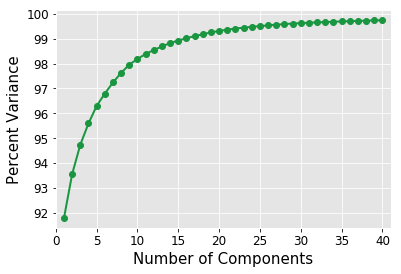

In [16]:
from pymks.tools import draw_component_variance


draw_component_variance(model.dimension_reducer.explained_variance_ratio_)

In [17]:
from sklearn.cross_validation import train_test_split


flat_shape = (X.shape[0],) + (X[0].size,)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(flat_shape), y,
                                                    test_size=0.2, random_state=3)
print(X_train.shape)
print(X_test.shape)

(960, 441)
(240, 441)


In [18]:
from sklearn.grid_search import GridSearchCV

In [20]:
params_to_tune = {'degree': np.arange(1, 4), 'n_components': np.arange(2, 12)}
fit_params = {'size': X[0].shape}
gs = GridSearchCV(model, params_to_tune, fit_params=fit_params).fit(X_train, y_train)

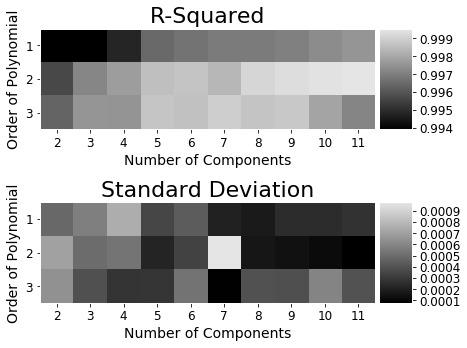

In [21]:
from pymks.tools import draw_gridscores_matrix


draw_gridscores_matrix(gs, ['n_components', 'degree'], score_label='R-Squared',
                       param_labels=['Number of Components', 'Order of Polynomial'])

In [22]:
print('Order of Polynomial', gs.best_estimator_.degree)
print('Number of Components', gs.best_estimator_.n_components)
print('R-squared Value', np.allclose(gs.score(X_test, y_test), 1, rtol=1e-2))

Order of Polynomial 2
Number of Components 11
R-squared Value True


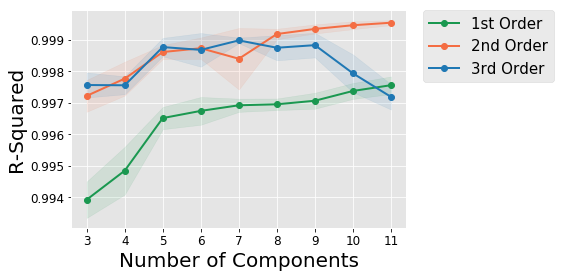

In [23]:
from pymks.tools import draw_gridscores


gs_deg_1 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 1][1:]
gs_deg_2 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 2][1:]
gs_deg_3 = [x for x in gs.grid_scores_ \
            if x.parameters['degree'] == 3][1:]

draw_gridscores([gs_deg_1,  gs_deg_2, gs_deg_3], 'n_components',
                data_labels=['1st Order', '2nd Order', '3rd Order'],
                param_label='Number of Components', score_label='R-Squared')

In [24]:
model = gs.best_estimator_